# Data Fusion Part II

In [1]:
import numpy as np
import glob
import open3d as o3d
import matplotlib.pyplot as plt
import cv2
from data_fusion_utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#Lets load lidar data
lidar_data_path = "../DATA/lidar_data/*.pcd"
lidar_file_names = sorted(glob.glob(lidar_data_path))
print(lidar_file_names[0:3])
#Lets load image data
image_data_path = "../DATA/image_02/data/*.png"
image_file_names = sorted(glob.glob(image_data_path))
print(image_file_names[0:3])
print("\n\n")
#Lets choose the first image and lidar point cloud 
index = 0
image_file = image_file_names[index]
lidar_file = lidar_file_names[index]
print(image_file)
print(lidar_file)

['../DATA/lidar_data\\0000000000.pcd', '../DATA/lidar_data\\0000000001.pcd', '../DATA/lidar_data\\0000000002.pcd']
['../DATA/image_02/data\\0000000000.png', '../DATA/image_02/data\\0000000001.png', '../DATA/image_02/data\\0000000002.png']



../DATA/image_02/data\0000000000.png
../DATA/lidar_data\0000000000.pcd


In [3]:
point_cloud = o3d.io.read_point_cloud(lidar_file)
X = np.asarray(point_cloud.points)
print(X.shape)

(122595, 3)


(375, 1242, 3)


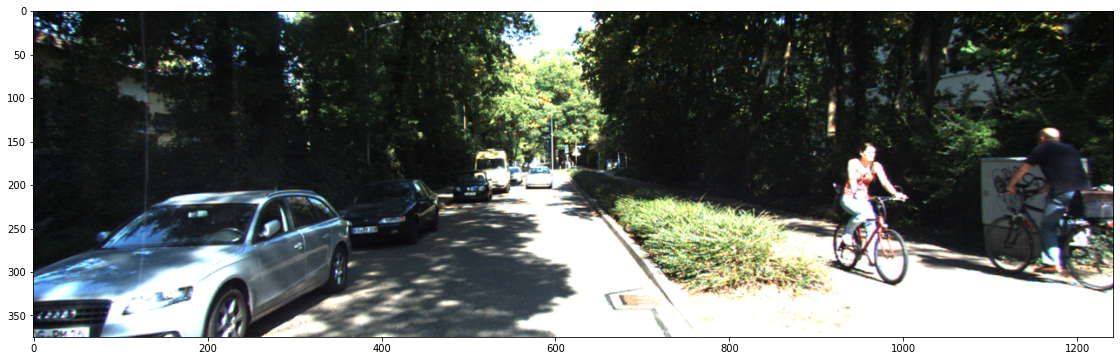

In [4]:
#Load image in RGB
img = cv2.cvtColor(cv2.imread(image_file),  cv2.COLOR_BGR2RGB)
#Let see the image dimensions
print(img.shape)
#Display image
plt.figure(figsize=(20, 6))
plt.imshow(img)

In [5]:
#Select points within 180 degrees
indices_180 = np.where(X[:, 0] >=  0)[0]
X_180 = X[indices_180]
point_cloud_180 = point_cloud.select_by_index(indices_180)
point_cloud_180.paint_uniform_color([1,1,1])
visualize_cloud([point_cloud_180])

In [6]:
#Lets get projection matrices
P, R_0, R_t = load_calibrations()

Matrix R0 (3, 3):
[[ 9.998817e-01  1.511453e-02 -2.841595e-03]
 [-1.511724e-02  9.998853e-01 -9.338510e-04]
 [ 2.827154e-03  9.766976e-04  9.999955e-01]]
Matrix P (3, 4):
[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
Matrix R (3, 3):
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01]
 [ 9.998621e-01  7.523790e-03  1.480755e-02]]
Vector t (3, 1):
[[-0.00406977]
 [-0.07631618]
 [-0.2717806 ]]
Matrix R|t (3, 4):
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01 -7.631618e-02]
 [ 9.998621e-01  7.523790e-03  1.480755e-02 -2.717806e-01]]


In [7]:
#Set frustum indices 
xmin, ymin, xmax, ymax = (0, 0, img.shape[1], img.shape[0])
#Project points 
Y = project_points(P, R_0, R_t, X_180)
indices_frustum = np.where((Y[:, 0] >= xmin) & (Y[:, 1] >= ymin) & (Y[:, 0] <= xmax) & (Y[:, 1] <=ymax))[0]
print(indices_frustum, len(indices_frustum))

[    0     1     2 ... 45098 45099 45100] 19167


In [8]:
X_frustum = X_180[indices_frustum]
print(X_frustum.shape)

(19167, 3)


In [9]:
point_cloud_frustum = point_cloud_180.select_by_index(indices_frustum)

In [10]:
point_cloud_frustum.paint_uniform_color([1, 0, 0])

PointCloud with 19167 points.

In [11]:
visualize_cloud([point_cloud_frustum, point_cloud_180])

In [12]:
lidar_mask = np.zeros_like(img[:, :, 0])
print(lidar_mask.shape)

(375, 1242)


In [13]:
lidar_mask 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [14]:
Y_frustum = project_points(P, R_0, R_t, X_frustum)
print(Y_frustum)

[[512.70170133 156.08574921]
 [511.53722648 156.10755205]
 [509.21785957 156.13939457]
 ...
 [619.62855429 371.93151005]
 [617.28009604 372.06738577]
 [616.10681656 371.97740903]]


In [15]:
for x, y in Y_frustum.astype(np.uint16):
    lidar_mask[y, x] =  1

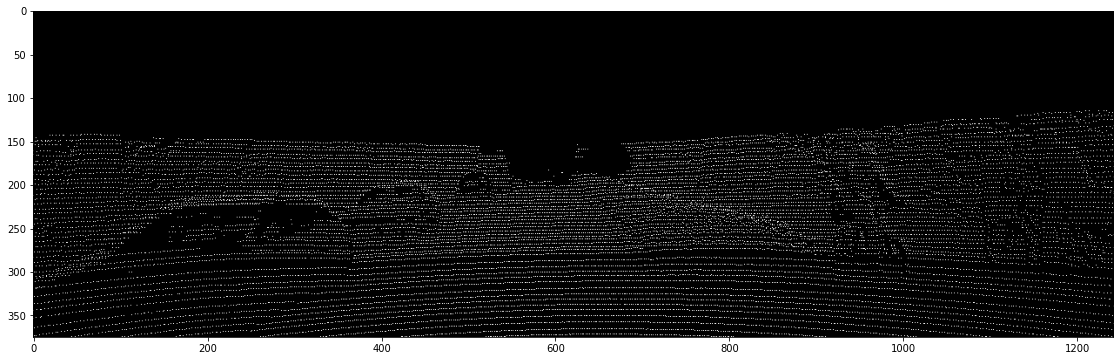

In [16]:
plt.figure(figsize=(20, 6))
plt.imshow(lidar_mask, cmap='gray')

In [17]:
#Import maskrcnn
import torch
import numpy as np
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as T
import matplotlib.pyplot as plt
from PIL import Image

In [18]:
#Set needed transfomrations to pass through deeplab_v3
transform = T.ToTensor()

In [19]:
# Preprocess the image
input_image = transform(img)
print(input_image.shape)

torch.Size([3, 375, 1242])


In [20]:
# Check if a GPU is available and if not, use a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [21]:
# Load the pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn_v2(MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
model.eval()

C:\Users\adela\anaconda3\envs\ComputerVision\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [22]:
#Move input image to available device
input_image  = input_image.to(device)

In [23]:
# Get predictions
with torch.no_grad():
    prediction = model([input_image])
# The prediction is a list of dictionaries, and we can extract the masks, labels, and boxes
pred_masks = prediction[0]['masks'].cpu().squeeze().numpy()
pred_boxes = prediction[0]['boxes'].cpu().numpy()
pred_labels = prediction[0]['labels'].cpu().numpy()
pred_scores = prediction[0]['scores'].cpu().numpy()

In [24]:
#Get classes and color map per calss
coco_classes, coco_color_map = get_coco_classes_and_color_map()
print(coco_classes)
print("\n")
print(coco_color_map)

{0: 'background', 1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell p

Class: person Confidence: 0.9988778233528137


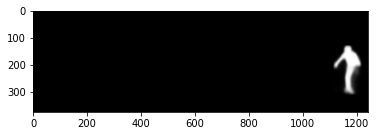

Class: person Confidence: 0.9974925518035889


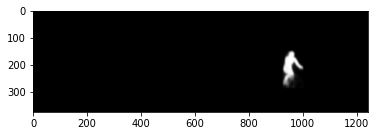

Class: car Confidence: 0.9971756935119629


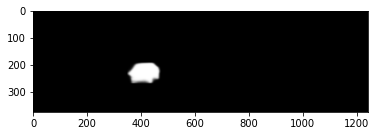

Class: car Confidence: 0.9971188306808472


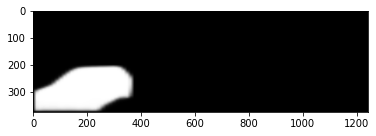

Class: car Confidence: 0.996431827545166


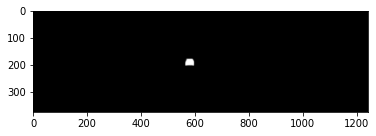

Class: bicycle Confidence: 0.9948322772979736


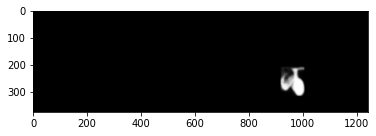

Class: car Confidence: 0.9943884015083313


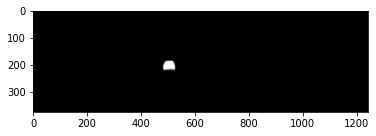

Class: bicycle Confidence: 0.9922688603401184


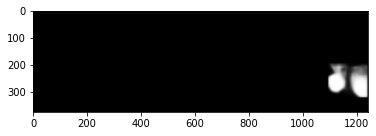

Class: car Confidence: 0.9887292981147766


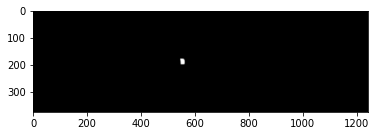

Class: truck Confidence: 0.8535704016685486


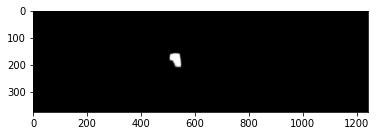

Class: car Confidence: 0.46641579270362854


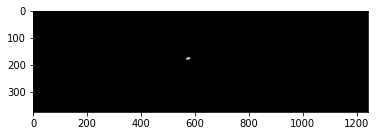

Class: car Confidence: 0.38262662291526794


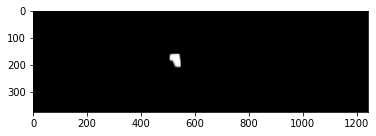

Class: car Confidence: 0.35416048765182495


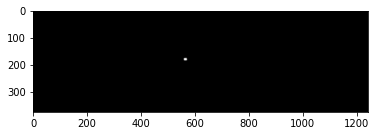

Class: bus Confidence: 0.2907188832759857


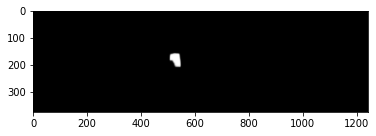

Class: traffic light Confidence: 0.20733675360679626


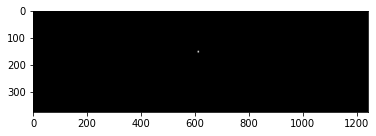

Class: bicycle Confidence: 0.16958768665790558


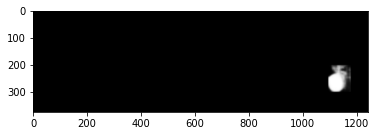

Class: motorcycle Confidence: 0.12392708659172058


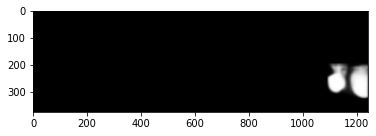

Class: handbag Confidence: 0.10812705010175705


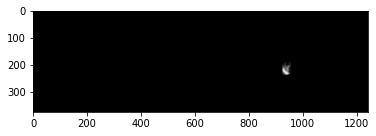

Class: car Confidence: 0.10283166170120239


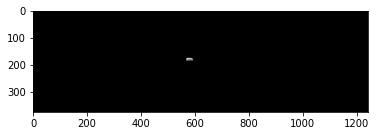

Class: bicycle Confidence: 0.10008887201547623


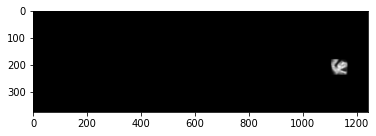

Class: car Confidence: 0.05874478071928024


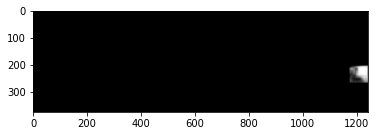

Class: car Confidence: 0.05573908984661102


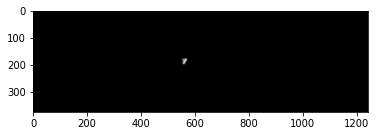

Class: traffic light Confidence: 0.053665414452552795


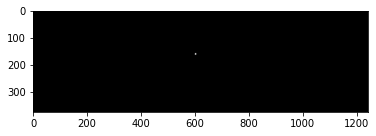

Class: car Confidence: 0.050372879952192307


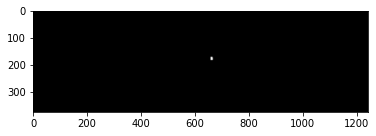

In [25]:
# print(coco_classes[pred_labels[0]])
# plt.imshow(pred_masks[0].squeeze().numpy())

for mask, label, score in zip(pred_masks, pred_labels, pred_scores):
    print(f"Class: {coco_classes[label]} Confidence: {score}")
    plt.imshow(mask, cmap='gray')
    plt.show()
    

In [26]:
#It appears tjhis is sorted by confidence scores we want to only use those we are highly confident in 
confidence_threshold = 0.85
high_conf_indices = np.where(pred_scores >= confidence_threshold)[0]
pred_masks = pred_masks[high_conf_indices]
pred_boxes = pred_boxes[high_conf_indices]
pred_labels = pred_labels[high_conf_indices]
pred_scores = pred_scores[high_conf_indices]

Class: person Confidence: 0.9988778233528137


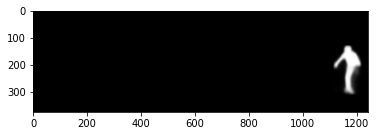

Class: person Confidence: 0.9974925518035889


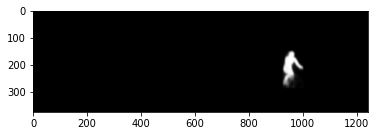

Class: car Confidence: 0.9971756935119629


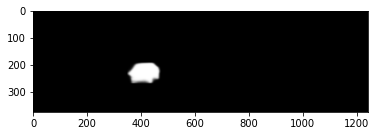

Class: car Confidence: 0.9971188306808472


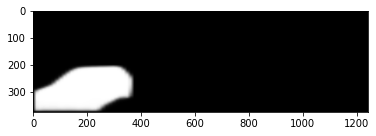

Class: car Confidence: 0.996431827545166


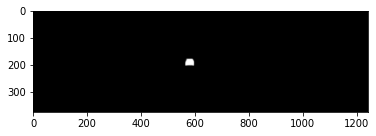

Class: bicycle Confidence: 0.9948322772979736


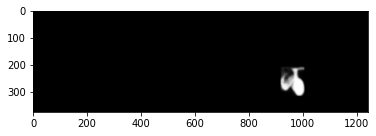

Class: car Confidence: 0.9943884015083313


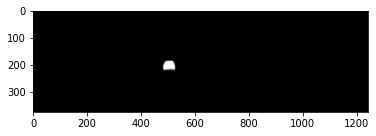

Class: bicycle Confidence: 0.9922688603401184


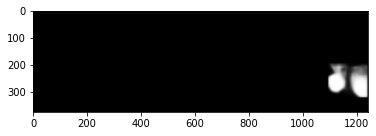

Class: car Confidence: 0.9887292981147766


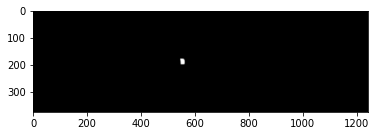

Class: truck Confidence: 0.8535704016685486


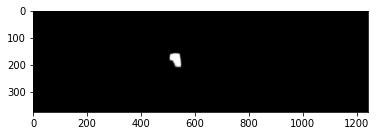

In [27]:
for mask, label, score in zip(pred_masks, pred_labels, pred_scores):
    print(f"Class: {coco_classes[label]} Confidence: {score}")
    plt.imshow(mask, cmap='gray')
    plt.show()

In [28]:
#Lets create an empty image to dispaly the semantic map
semantic_image = np.zeros_like(img)
semantic_image.shape

(375, 1242, 3)

person


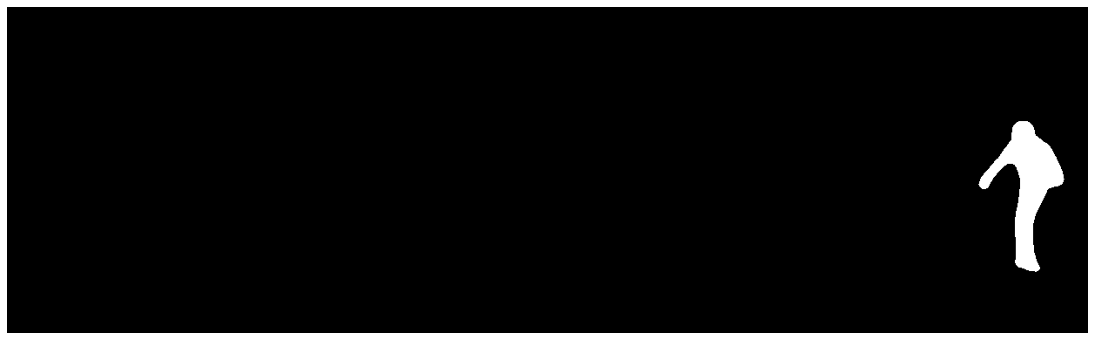

In [29]:
#Lets check out the map range for interesting things talk about it then do the thresholding 
mask = pred_masks[0] > 0.5
mask = mask.astype(np.uint8)

print(coco_classes[pred_labels[0]])
plt.figure(figsize=(20, 6))
plt.imshow(mask, cmap='gray')
plt.axis("off")
plt.show()

In [30]:
semantic_image[mask == 1] = coco_color_map[pred_labels[0]]

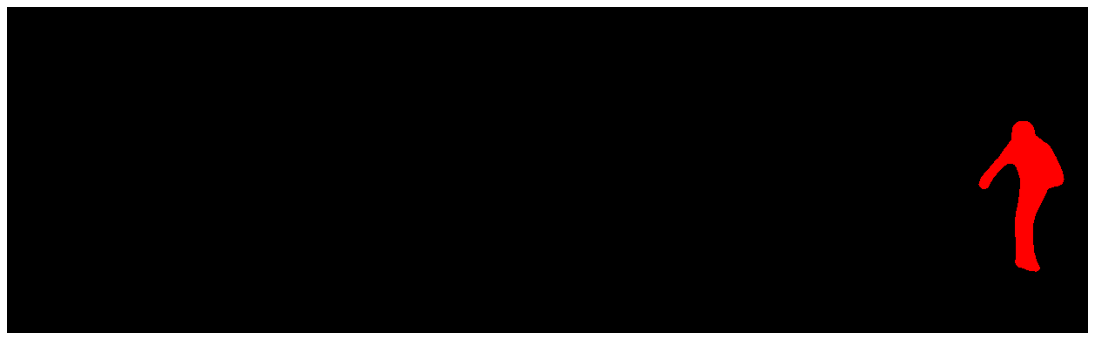

In [31]:
plt.figure(figsize=(20, 6))
plt.imshow(semantic_image)
plt.axis("off")
plt.show()

In [32]:
#Create sematic map
semantic_image = np.zeros_like(img)
#Create a per pixel score of class of only 1 channel this will be used decorate the points cloud later on
per_pixel_score = np.zeros_like(pred_masks[0])

for mask, label in zip(pred_masks, pred_labels):
    #Threshold mask as output was float32 then convert to np.uint8
    mask = mask  > 0.5
    mask = mask.astype(np.uint8)
    semantic_image[mask == 1] = coco_color_map[label]
    per_pixel_score[mask == 1] = label

#Set any left over black pixels from 0 to calss 0 which is just background or noise
# This will set all pixels that are black (0, 0, 0) to white (255, 255, 255)
semantic_zeros = np.all(semantic_image == 0, axis=-1)
semantic_image[semantic_zeros] = coco_color_map[0]
#Per pixel score background/noise is already zeros so there is no need to update


    
        

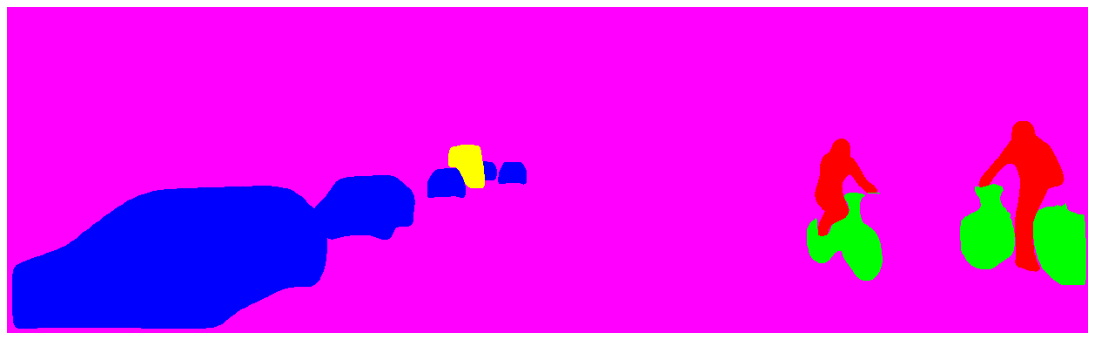

In [33]:
plt.figure(figsize=(20, 6))
plt.imshow(semantic_image)
plt.axis("off")
plt.show()

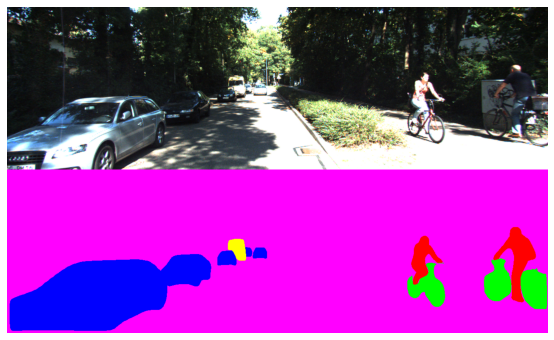

In [34]:
#Lets stack them together
plt.figure(figsize=(20, 6))
plt.imshow(np.vstack((img, semantic_image)))
plt.axis("off")
plt.show()

In [35]:
#Let us now decorate the point cloud
np.unique(per_pixel_score)

array([0., 1., 2., 3., 8.], dtype=float32)

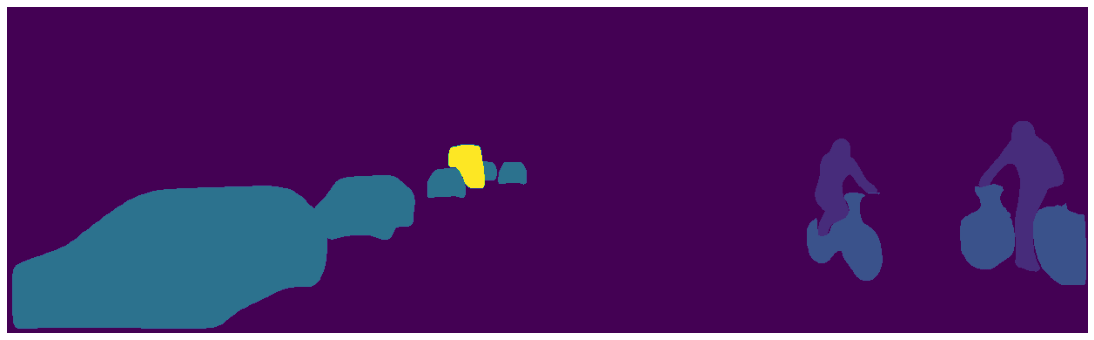

In [36]:
plt.figure(figsize=(20, 6))
plt.imshow(per_pixel_score)
plt.axis('off')
plt.show()

In [37]:
#Y_frustum contains our point in 2D and X_frustum 
print(Y_frustum)
print(X_frustum)

[[512.70170133 156.08574921]
 [511.53722648 156.10755205]
 [509.21785957 156.13939457]
 ...
 [619.62855429 371.93151005]
 [617.28009604 372.06738577]
 [616.10681656 371.97740903]]
[[ 5.73889999e+01  7.92000008e+00  2.16799998e+00]
 [ 5.74720001e+01  8.02400017e+00  2.17100000e+00]
 [ 5.75890007e+01  8.22500038e+00  2.17600012e+00]
 ...
 [ 6.44199991e+00 -3.20000015e-02 -1.68400002e+00]
 [ 6.45400000e+00 -1.20000001e-02 -1.68799996e+00]
 [ 6.44600010e+00 -2.00000009e-03 -1.68499994e+00]]


In [38]:
Y_frustum_int = Y_frustum.astype(np.uint16)
print(Y_frustum_int)

[[512 156]
 [511 156]
 [509 156]
 ...
 [619 371]
 [617 372]
 [616 371]]


In [39]:
#Let us now assign a per point semantic label to the lidar point cloud
labels = np.zeros(Y_frustum_int.shape[0]).astype(np.uint16)
for y in range(per_pixel_score.shape[0]):
    for x in range(per_pixel_score.shape[1]):
        #Get indices where any pixels in Y_frustum_int are the current y,x pixel
        indices = np.where((Y_frustum_int[:, 0] == x) & (Y_frustum_int[:, 1] == y))[0]
        labels[indices]  = per_pixel_score[y, x]
        

In [40]:
np.unique(labels)

array([0, 1, 2, 3, 8], dtype=uint16)

In [41]:
print(len(labels))
print(X_frustum.shape)

19167
(19167, 3)


In [42]:
#Now lets create an empty lidar image
lidar_image = np.zeros_like(img)
print(lidar_image.shape)
for i, (x, y) in enumerate(Y_frustum.astype(np.uint16)):
    #Draw a circle with radius 1 at (x, y) position
    cv2.circle(lidar_image, (x, y), radius=1, color=coco_color_map[labels[i]], thickness=-1)  # thickness=-1 fills the circle

(375, 1242, 3)


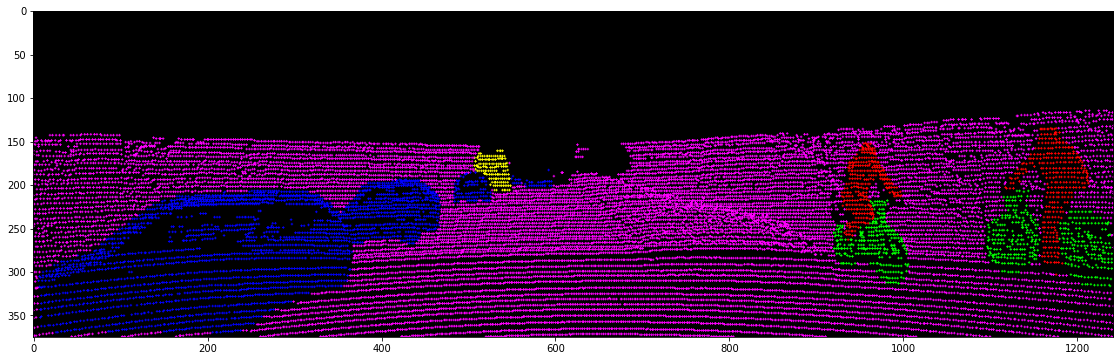

In [43]:
plt.figure(figsize=(20, 6))
plt.imshow(lidar_image)

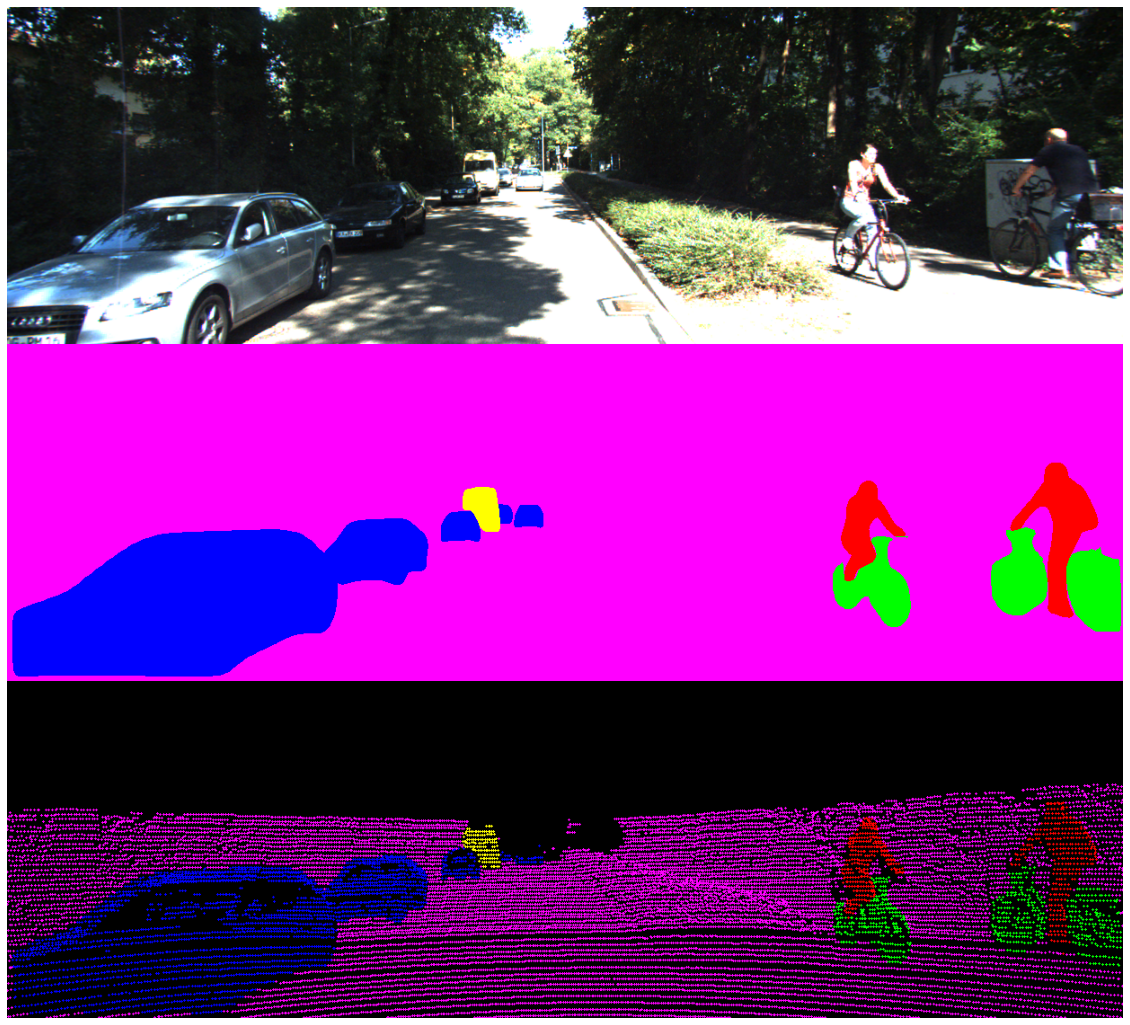

In [44]:
#Lets stack them together
plt.figure(figsize=(20, 20))
plt.imshow(np.vstack((img, semantic_image, lidar_image)))
plt.axis("off")
plt.show()

In [49]:
point_cloud.paint_uniform_color([1, 1, 1])

PointCloud with 122595 points.

In [50]:
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [51]:
np.unique(labels)

array([0, 1, 2, 3, 8], dtype=uint16)

In [52]:
lidar_color_map = np.array([coco_color_map[label] for label in labels])

In [53]:
point_cloud_frustum.colors = o3d.utility.Vector3dVector(lidar_color_map)

In [54]:
visualize_cloud([point_cloud_frustum, point_cloud])

# PointPainting 

Now that we have everything we need lets I have created a python class that uses all the functions needed to peform pointating lets go over it. 

In [55]:
#Lets import the class!
%load_ext autoreload
%autoreload 2
from point_painter import PointPainter

Next we instantiate the class we provide the following input parameters `P`, `R_0`, `R_t` and `conf`for confidence optional as this is already set to 0.85

In [56]:
#Instantiate point painter class
cloud_painter = PointPainter(P, R_0, R_t)

### Get MaskRCNN predictions
Lets go over the different methods, first we have `get_maskrcnn_predictions` this are just the simple output predictions of maskrcnn given the confidence using an input image. This will return `pred_mask`, `pred_labels`, `pred_scores`

In [57]:
pred_masks, pred_labels, pred_scores = cloud_painter.get_maskrcnn_predictions(img)

In [58]:
print(pred_masks.shape)
print([cloud_painter.coco_classes[label] for label in pred_labels])
print(pred_scores)

(10, 375, 1242)
['person', 'person', 'car', 'car', 'car', 'bicycle', 'car', 'bicycle', 'car', 'truck']
[0.9988778  0.99749255 0.9971757  0.99711883 0.9964318  0.9948323
 0.9943884  0.99226886 0.9887293  0.8535704 ]


### Get Semantic Image and Per Pixel Score

The `get_semantic_image_and_per_pixel_score` will provide us with the segmantic color image and pixel score image map. It has input arguments of `image`, `pred_masks`, and `pred_labels` if no argument is provided for `pred_mask` or `pred_labels` the function will infer on the image first using MaskRCNN. However, here we already have these values. 

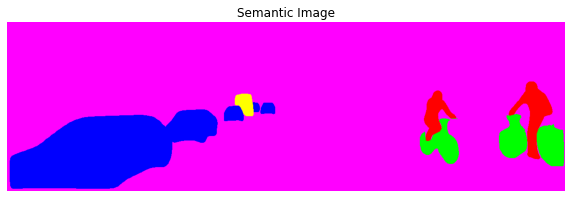

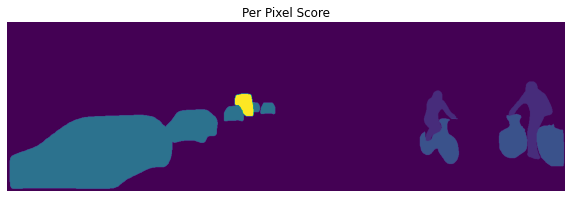

In [59]:
semantic_image, per_pixel_score =  cloud_painter.get_semantic_image_and_per_pixel_score(img, pred_masks, pred_labels)

#Plot images
plt.figure(figsize=(10, 6))
plt.imshow(semantic_image)
plt.title('Semantic Image')
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(per_pixel_score)
plt.title('Per Pixel Score')
plt.axis("off")
plt.show()

### Decorate Point Cloud

The `decorate_point_cloud` method will decorate the point cloud and provide you with the lidar `labels`, `lidar_color_map`, `lidar_image`
All we have to do is provide the image, lidar points and `per_pixel_score` if per_pixel_score is not defined or is emtpty then the function will infer on the image to get the `per_pixel_score`

In [60]:
labels, lidar_color_map, lidar_image = cloud_painter.decorate_point_cloud(img, X_frustum, per_pixel_score)

[0 1 2 3 8]
[[255   0 255]
 [255   0 255]
 [255   0 255]
 ...
 [255   0 255]
 [255   0 255]
 [255   0 255]]


(-0.5, 1241.5, 374.5, -0.5)

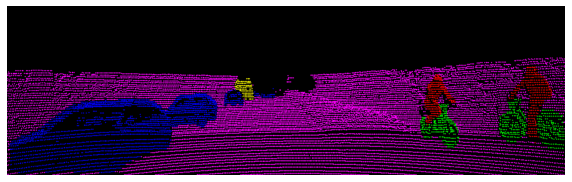

In [61]:
print(np.unique(labels))
print(lidar_color_map)
plt.figure(figsize=(10, 6))
plt.imshow(lidar_image)
plt.axis('off')

### Run Full Stack

The `paintCloud` is the main method it runs all the other functions from inference to point painting and ruturns a dictionary with everthing. Its input parameters are just the image and the lidar points

In [62]:
point_painting_detections = cloud_painter.paintCloud(img, X_frustum)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dict_keys(['pred_mask', 'pred_labels', 'pred_scores', 'semantic_image', 'per_pixel_score', 'lidar_labels', 'lidar_color_map', 'lidar_image'])


(-0.5, 1241.5, 1499.5, -0.5)

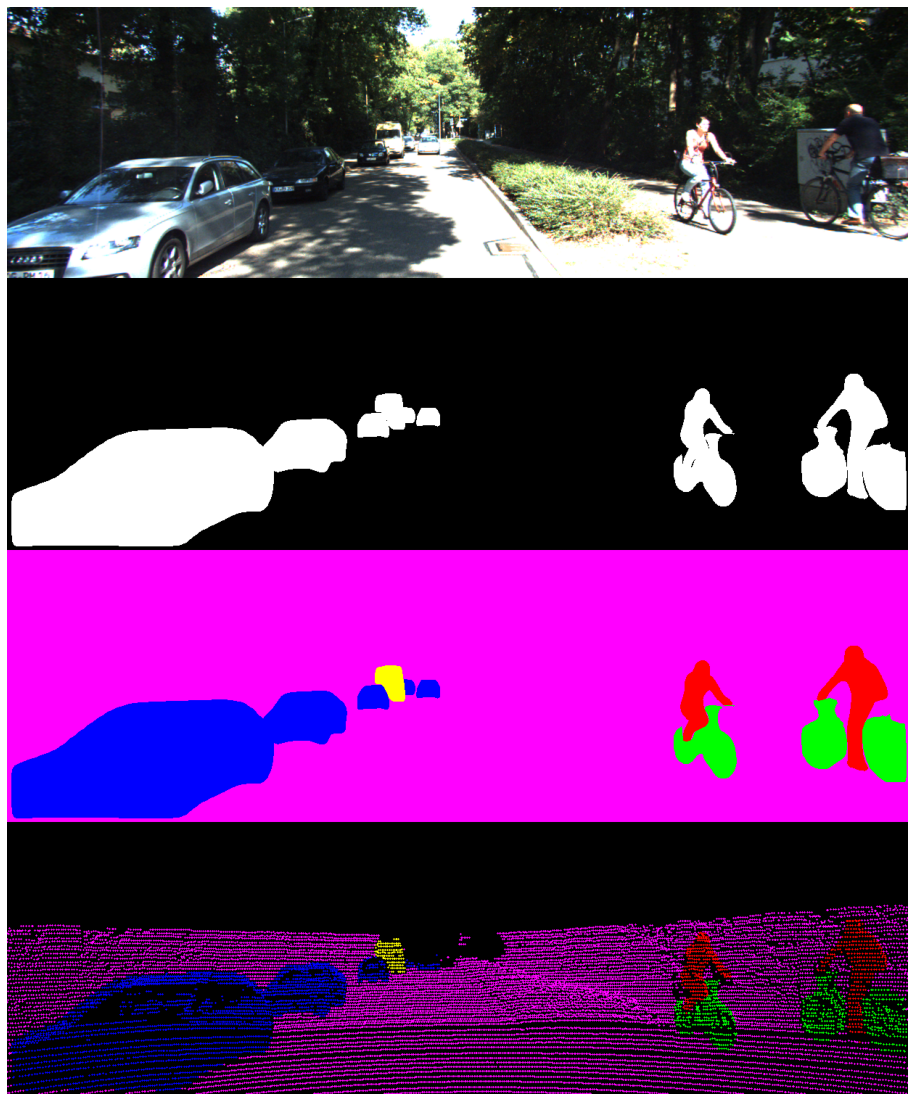

In [63]:
print(point_painting_detections.keys())
#Lets stack the image from img, per_pixel_score, segementation, and lidar_image
full_stack_image = np.vstack((img, np.stack((point_painting_detections['per_pixel_score'],)*3, axis=-1)*255, 
                             point_painting_detections['semantic_image'], point_painting_detections['lidar_image']))/255
plt.figure(figsize=(40, 20))
plt.imshow(full_stack_image)
plt.axis('off')


# GIF Creation

Lets create a video that shows all these images in motion, we already have the `PointPainter` class instantiated

In [120]:
#Lets create a gif video 
from tqdm import tqdm
#Create a list of gif images 
gif_images = []
for i in tqdm(range(len(image_file_names))):
    #Load image
    IMAGE = cv2.cvtColor(cv2.imread(image_file_names[i]),  cv2.COLOR_BGR2RGB)
    #Load lidar
    LIDAR = np.asarray(o3d.io.read_point_cloud(lidar_file_names[i]).points)
    #Select points within 180 degrees
    indices_180 = np.where(LIDAR[:, 0] >=  0)[0]
    LIDAR_FOV_180 = LIDAR[indices_180]
    #Select Frustum 
    Y = project_points(P, R_0, R_t, LIDAR_FOV_180)
    indices_frustum = np.where((Y[:, 0] >= xmin) & (Y[:, 1] >= ymin) & (Y[:, 0] <= xmax) & (Y[:, 1] <=ymax))[0]
    X_FRUSTUM = LIDAR_FOV_180[indices_frustum]
    
    #Get all detections
    detections = cloud_painter.paintCloud(IMAGE, X_FRUSTUM)
    SEMANTIC_IMAGE = detections['semantic_image']
    LIDAR_IMAGE = detections['lidar_image']

    #Lets add top left text label
    # Define the text properties
    position = (10, 30)  # Position of text (x, y) from the top-left corner
    font = cv2.FONT_HERSHEY_SIMPLEX  # Font type
    font_scale = 1  # Font size
    thickness = 2  # Font thickness
    
    text = "Original Image" 
    color = (255, 255, 255)
    # Add text to the image
    cv2.putText(IMAGE, text, position, font, font_scale, color, thickness)

    text = "MaskRCNN Semantic Image" 
    color = (0, 0, 0)
    # Add text to the image
    cv2.putText(SEMANTIC_IMAGE, text, position, font, font_scale, color, thickness)

    text = "Decorated Lidar Image" 
    color = (255, 255, 255)
    # Add text to the image
    cv2.putText(LIDAR_IMAGE, text, position, font, font_scale, color, thickness)

    

    
    
    
    #Append and stack below original image
    full_stack_image = np.vstack((IMAGE, SEMANTIC_IMAGE, LIDAR_IMAGE))
    gif_images.append(full_stack_image)

100%|██████████████████████████████████████████████████████████████████████████████████| 86/86 [13:28<00:00,  9.40s/it]


In [121]:
# Save the images as a GIF
import imageio
#Set duration of each each frame 
frame_duration = 1
imageio.mimsave("semantic_scene_map.gif", gif_images, duration=frame_duration, loop=0)

# Output

<img src="semantic_scene_map.gif" alt="Semantic-Map" style="loop:infinite;">

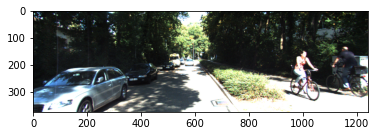

In [124]:
plt.imshow(img)

# Unsupervised 3D object Detection

In [66]:
plt.figure(figsize=(40, 20))
plt.imshow(gif_images[0])
plt.axis('off')
cv2.imwrite('point_painting_output_example.png', cv2.cvtColor(gif_images[0], cv2.COLOR_RGB2BGR)) 

NameError: name 'gif_images' is not defined

<Figure size 2880x1440 with 0 Axes>

True

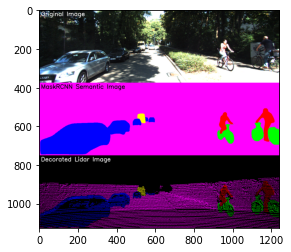

In [70]:
example = cv2.imread('point_painting_output_example.png')
plt.imshow(example)
cv2.imwrite('point_painting_output_example.png', cv2.cvtColor(example, cv2.COLOR_RGB2BGR)) 


In [126]:
labels, lidar_color_map, lidar_image = cloud_painter.decorate_point_cloud(img, X_frustum, per_pixel_score)

In [64]:
point_cloud_frustum.paint_uniform_color([1,1, 1])
point_cloud_frustum.colors = o3d.utility.Vector3dVector(lidar_color_map)
visualize_cloud([point_cloud_frustum, point_cloud])

In [ ]:
visualize_cloud([point_cloud_frustum, point_cloud])